In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

!pip install contractions
!pip install beautifulsoup4
!pip install gensim
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install yellowbrick
!pip3 install truecase
!pip install ekphrasis
!pip install hyperopt
!pip install seaborn
!python -m spacy download en_core_web_sm
!pip install ray

     |████████████████████████████████| 284 kB 4.9 MB/s 
     |████████████████████████████████| 321 kB 88.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85456 sha256=81537005965f834fd934a1d735203f05aaedfd556afd474a8fdf1ec1f459e474
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 951 kB 61.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

     |████████████████████████████████| 6.0 MB 5.0 MB/s            
     |████████████████████████████████| 10.1 MB 34.3 MB/s            
     |████████████████████████████████| 42 kB 1.8 MB/s             
     |████████████████████████████████| 628 kB 94.5 MB/s            
     |████████████████████████████████| 451 kB 68.6 MB/s            
     |████████████████████████████████| 181 kB 101.1 MB/s            
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully un

In [ ]:
from preprocessor import Preprocessor
from data_understanding import DataUnderstanding
from lstm import TweetClassifier, AccountClassifier
from dataset_loader import DatasetMaper, DataSetLoader, DatasetMaperList
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from keras.preprocessing import sequence
import gensim.models.fasttext as fasttext
import pickle
import pandas as pd
import numpy as np
import dataset_loader
from hyperopt import fmin, tpe, hp
from functools import partial
from pathlib import Path
from hyperopt import hp

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
/usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [ ]:
RUN_ON_SERVER = True
LOAD_PREPROCESSED_DATA = True
LOAD_TRAINED_CLASSIFIER = True

if RUN_ON_SERVER:
    test_path = 'gdrive/MyDrive/Data/test/en/'
    train_path = 'gdrive/MyDrive/Data/training/en/'
    glove_path = "gdrive/MyDrive/Data/glove.twitter.27B/glove.twitter.27B.50d.txt"
    glove_out = 'emb_word2vec_format.txt'
    #glove_out = 'emb_word2vec_format.txt'
else:
    test_path = '../Data/test/en/'
    train_path = '../Data/training/en/'
    glove_path = '../Data/glove.twitter.27B/glove.twitter.27B.50d.txt'
    glove_out = '../Glove/emb_word2vec_format.txt'
    
earlybird_path = '../Data/earlybird/en/'

TWEET_LENGTH = 40
VOCABULARY_SIZE = 2000
LEARNING_RATE = 0.005
BATCH_SIZE = 64
ACCOUNT_TWEETS_NUMBER = 100
DATA_UNDERSTANDING_ENABLED = False
EMBEDDING_DIM = 50
tweet_classifier_path = 'tweet_classifier'
account_classifier_path = 'account_classifier'

In [ ]:
def evaulate(y_pred, y):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    print(f'Accuracy: {acc}')
    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    
    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    return f1
    
def get_tweet_based_account_prediction(x, y, classifier):
    accounts_pred = []
    accounts_probabilities = []
    accounts_hidden_states = []
    y_tweets = []
    y_tweets_probabilities = []
    i = 0
    for accounts in x:
        proccessed_percante = i/len(x)*100
        if i%100 == 0:
            print(f'Predicted {proccessed_percante}% of accounts')
        y_account = [y[i]]*len(accounts)    
        #y_pred, h = classifier.get_prediction(classifier, accounts, y_account)
        y_pred, h, y_probabilites, _ = classifier.get_prediction(accounts, y_account)
        accounts_pred.append(y_pred)
        accounts_probabilities.append(y_probabilites)
        y_tweets_probabilities.extend(y_probabilites)
        y_tweets.extend(y_pred)
        accounts_hidden_states.append(h)
        i += 1
    return accounts_pred, accounts_hidden_states, y_tweets, y_tweets_probabilities,  accounts_probabilities

def get_majority_vote_for_account(account):
    number_of_bots = sum(account)
    return 1 if number_of_bots >= 50 else 0
    
def get_majority_vote(accounts):
    votes = []
    for account in accounts:
        votes.append(get_majority_vote_for_account(account))
    return votes

def write_to_file(data, name):
    output = open(name+'.pkl', 'wb')
    pickle.dump(data, output)

def get_from_file(name):
    pkl_file = open(name +'.pkl', 'rb')
    return pickle.load(pkl_file)

def save_preprocessed_data(x_test, y_test, x, y, x_val, y_val, hashes_val, hashes_test, hashes_train):
    print('Saving preprocessed data to Files')
    Path('serialization').mkdir(parents=True, exist_ok=True)
    write_to_file(x_test, 'serialization/x_test')
    write_to_file(y_test, 'serialization/y_test')
    write_to_file(x, 'serialization/x')
    write_to_file(y, 'serialization/y')
    write_to_file(x_val, 'serialization/x_val')
    write_to_file(y_val, 'serialization/y_val')
    
    write_to_file(hashes_test, 'serialization/hashes_test')
    write_to_file(hashes_train, 'serialization/hashes_train')
    write_to_file(hashes_val, 'serialization/hashes_val')

In [ ]:
data_understander = DataUnderstanding()
preprocessor = Preprocessor()
dataset_loader = DataSetLoader(train_path)

In [ ]:
glove2word2vec(glove_input_file=glove_path, word2vec_output_file=glove_out)
embedding = gensim.models.KeyedVectors.load_word2vec_format(glove_out)


In [ ]:
if LOAD_PREPROCESSED_DATA:
    print('Getting serailized data\n')
    x_test = get_from_file('x_test')
    y_test = get_from_file('y_test')
    x = get_from_file('x')
    y = get_from_file('y')
    x_val = get_from_file('x_val')
    y_val = get_from_file('y_val')
    #x_train_aug = get_from_file('x_train_augmented')
    #y_train_aug = get_from_file('y_train_augmented')
    hashes_test = get_from_file('hashes_test')
    hashes_train = get_from_file('hashes_train')
    hashes_val = get_from_file('hashes_val')
    #hashes_train_aug = get_from_file('hashes_train_augmented')

    #x, y, x_train, y_train, x_val, y_val, x_padded_train, x_padded_val, x_tweets_train, y_tweets_train, x_tweets_val, y_tweets_val = dataset_loader.get_all_data_from_x_y(x ,y, embedding)
    x_test, y_test, x_padded_test, x_tweets_test, y_tweets_test = dataset_loader.get_all_data_from_x_y(x_test, y_test, embedding, shouldSplit=False)
    x_train, y_train, x_padded_train, x_tweets_train, y_tweets_train = dataset_loader.get_all_data_from_x_y(x, y, embedding, shouldSplit=False)
    x_train, y_train, x_padded_train, x_tweets_train, y_tweets_train = dataset_loader.get_all_data_from_x_y(x, y, embedding, shouldSplit=False)
    x_val, y_val, x_padded_val, x_tweets_val, y_tweets_val = dataset_loader.get_all_data_from_x_y(x_val, y_val, embedding, shouldSplit=False)
    #x_train_aug, y_train_aug, x_padded_train_aug, x_tweets_train_aug, y_tweets_train_aug = dataset_loader.get_all_data_from_x_y(x_train_aug, y_train_aug, embedding, shouldSplit=False)
else:
    print('Getting training and test set')
    #x, y, x_train, y_train, x_val, y_val, x_padded_train, x_padded_val, x_tweets_train, y_tweets_train, x_tweets_val, y_tweets_val, hashes_train = dataset_loader.get_all_x_y(earlybird_path, embedding)
    x_test, y_test, x_padded_test, x_tweets_test, y_tweets_test, hashes_test = dataset_loader.get_all_x_y(test_path, embedding, shouldSplit=False)
    x_train, y_train, x_padded_train, x_tweets_train, y_tweets_train, hashes_train = dataset_loader.get_all_x_y(train_path, embedding, truth='truth-train.txt', shouldSplit=False)
    x_val, y_val, x_padded_val, x_tweets_val, y_tweets_val, hashes_val = dataset_loader.get_all_x_y(train_path, embedding, truth='truth-dev.txt', shouldSplit=False)

    save_preprocessed_data(x_test, y_test, x_train, y_train, x_val, y_val, hashes_val, hashes_test, hashes_train)#

Getting serailized data



In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
print('Loading pre-trained model')
tweet_classifier = torch.load('gdrive/MyDrive/Data/tweet_classifier')

Loading pre-trained model


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
import time
start = time.time()
print('\nTraining set')
tweet_based_accounts_train_pred, accounts_h_train, y_tweets_pred_train, y_tweets_probabilities_train, tweet_based_account_train_probabilites = get_tweet_based_account_prediction(x_padded_train, y_train, tweet_classifier)

account_majority_vote_train = get_majority_vote(tweet_based_accounts_train_pred)
account_probability_vote_train = get_majority_vote(tweet_based_account_train_probabilites)

print('\nEvaulation of Tweet Prediction')
evaulate(y_tweets_pred_train, y_tweets_train)
evaulate(account_majority_vote_train, y_train)
evaulate(account_probability_vote_train, y_train)

print('\Test set:')
tweet_based_accounts_pred_test, accounts_h_test, y_tweets_test_pred, y_tweets_probabilities_test, tweet_based_account_probabilites_test = get_tweet_based_account_prediction(x_padded_test, y_test, tweet_classifier)

account_majority_vote_test = get_majority_vote(tweet_based_accounts_pred_test)
account_probability_vote_test = get_majority_vote(tweet_based_account_probabilites_test)

print('\nEvaulation of Tweet Prediction')
evaulate(y_tweets_test_pred, y_tweets_test)
evaulate(account_majority_vote_test, y_test)
evaulate(account_probability_vote_test, y_test)

print('\nValidation Set:')
tweet_based_accounts_val_pred, accounts_h_val, y_tweets_val_pred, y_tweets_probabilities_val, tweet_based_account_probabilites_val = get_tweet_based_account_prediction(x_padded_val, y_val, tweet_classifier)
evaulate(y_tweets_val_pred, y_tweets_val)
end = time.time()
print(end-start)
print(start)
print(end)


Training set
Predicted 0.0% of accounts
Predicted 3.4722222222222223% of accounts
Predicted 6.944444444444445% of accounts
Predicted 10.416666666666668% of accounts
Predicted 13.88888888888889% of accounts
Predicted 17.36111111111111% of accounts
Predicted 20.833333333333336% of accounts
Predicted 24.305555555555554% of accounts
Predicted 27.77777777777778% of accounts
Predicted 31.25% of accounts
Predicted 34.72222222222222% of accounts
Predicted 38.19444444444444% of accounts
Predicted 41.66666666666667% of accounts
Predicted 45.13888888888889% of accounts
Predicted 48.61111111111111% of accounts
Predicted 52.083333333333336% of accounts
Predicted 55.55555555555556% of accounts
Predicted 59.02777777777778% of accounts
Predicted 62.5% of accounts
Predicted 65.97222222222221% of accounts
Predicted 69.44444444444444% of accounts
Predicted 72.91666666666666% of accounts
Predicted 76.38888888888889% of accounts
Predicted 79.86111111111111% of accounts
Predicted 83.33333333333334% of acco

In [ ]:
import datetime
print(datetime.datetime.now().time())

13:57:37.323575


In [ ]:
accounts_h_train_norm = preprocessor.scale_hidden_states(accounts_h_train)
accounts_h_val_norm = preprocessor.scale_hidden_states(accounts_h_val, should_fit=False)
accounts_h_test_norm = preprocessor.scale_hidden_states(accounts_h_test, should_fit=False)

In [ ]:
from data_augmenter import DataAugmenter
augmenter = DataAugmenter(accounts_h_train_norm,y_train, 100, 32)
accounts_h_train_augmented, y_augmented, lengths = augmenter.augment([98, 99, 100])

Generating for 98
Generating for 99
Generating for 100
[98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 

In [ ]:
lengths_norm = [100]*len(accounts_h_train_norm)
print(len(accounts_h_val_norm))
#lengths_norm

1240


In [ ]:
account_classifier = AccountClassifier(input_size=32,
                                     batch_size = 64,
                                     lstm_layers = 2,
                                     lr = 0.008054089118348883,
                                     lstm_hidden_size=128,
                                     fc_drouput=0.09187244345294404,
                                     lstm_dropout=0.4989474677953669,
                                     nn_size = 128,
                                     weight_decay=9.174335087470999e-08,
                                     bidirectional = True, n_eopchs_stop=40)
 
account_classifier.train_model(accounts_h_train_norm, y_train, accounts_h_val_norm, lengths_norm, y_val, epochs=250)

Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 128, num_layers=2, dropout=0.4989474677953669, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.09187244345294404, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 1.2284270154105292 Training Accuracy 0.5652777777777778 Validation Accuracy: 0.6008064516129032, Validation loss: 0.6423677091364821
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.6011717120806376 Training Accuracy 0.6354166666666666 Validation Accuracy: 0.7459677419354839, Validation loss: 0.5837601121659616
Re-setting early stopping
Training epoch 2
Epoch: 2 Training loss: 0.5682068619463179 Training Accuracy 0.7159722222222222 Validation Accuracy: 0.7451612903225806, Validation loss: 0.5155375446066413
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0.442618392242325

In [ ]:
pred, _, prob = account_classifier.get_prediction(accounts_h_test_norm, y_test)

In [ ]:
evaulate(pred, y_test)

Accuracy: 0.8689393939393939
F1 Score: 0.872700515084621
Precision: 0.8483547925608012
Recall: 0.8984848484848484
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1320
           1       0.85      0.90      0.87      1320

    accuracy                           0.87      2640
   macro avg       0.87      0.87      0.87      2640
weighted avg       0.87      0.87      0.87      2640

Confusion Matrix:
[[1108  212]
 [ 134 1186]]


0.872700515084621

In [ ]:
h_train = accounts_h_train_norm + accounts_h_val_norm
h_train = np.array(h_train)
y_train_kfold = y_train + y_val
y_train_kfold = np.array(y_train_kfold)

In [ ]:
h_train_aug = accounts_h_train_augmented + accounts_h_val_norm
h_train_aug = np.array(h_train_aug)
y_train_kfold_aug = y_augmented + y_val
y_train_kfold_aug = np.array(y_train_kfold_aug)
lengths = lengths.extend([100]*len(accounts_h_val_norm))
lengths = np.array(lengths)

09:21:39.406897
Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.09199872443452944, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Epoch: 0 Training loss: 0.7388629557994696 Training Accuracy 0.6134708737864077 Validation Accuracy: 0.5618932038834952, Validation loss: 0.6149664018178829
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.5587146350970635 Training Accuracy 0.7120752427184466 Validation Accuracy: 0.6177184466019418, Validation loss: 0.5726878865137673
Re-setting early stopping
Training epoch 2
Epoch: 2 Training loss: 0.5168809208732384 Training Accuracy 0.7594053398058253 Validation Accuracy: 0.6043689320388349, Validation loss: 0.623947613342573
Possibly early stopping will be neccesary 1
Training epoch 3
Epoch: 3 Training loss: 0.4329775534570217 Training Accuracy 0.8401092233009708 Validation Accuracy: 0.8580097087378641, Validation loss: 0.3928762721752542
Re-setting early stopping
Training epoch 4
Epoch: 4 Training loss: 0.35028087046857065 Training Accuracy 0.8859223300970874 Validation Accuracy: 0.8689320388349514, Validation loss: 0.35659879920782367
Re-setting early stoppin

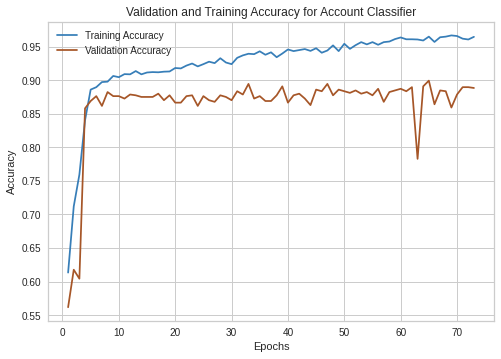

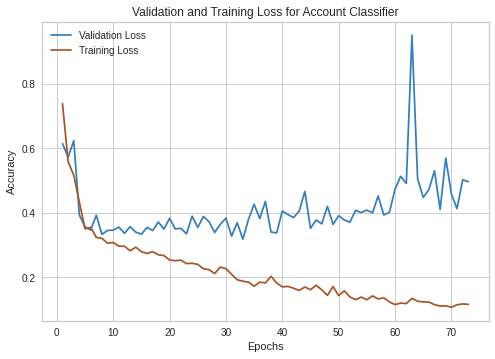

Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.09199872443452944, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 0.7188655865880159 Training Accuracy 0.5779733009708737 Validation Accuracy: 0.595873786407767, Validation loss: 0.5935546505509071
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.5850459663913801 Training Accuracy 0.6799150485436893 Validation Accuracy: 0.595873786407767, Validation loss: 0.5975912947978235
Possibly early stopping will be neccesary 1
Training epoch 2
Epoch: 2 Training loss: 0.5572247270208138 Training Accuracy 0.7387742718446602 Validation Accuracy: 0.816747572815534, Validation loss: 0.4541903089277573
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0.45

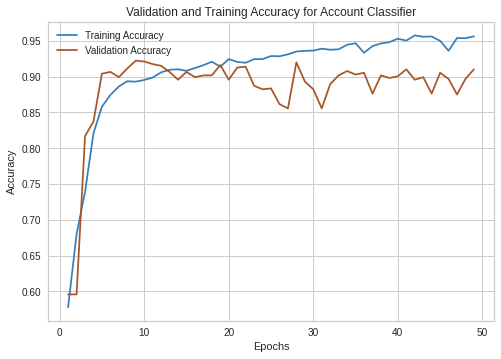

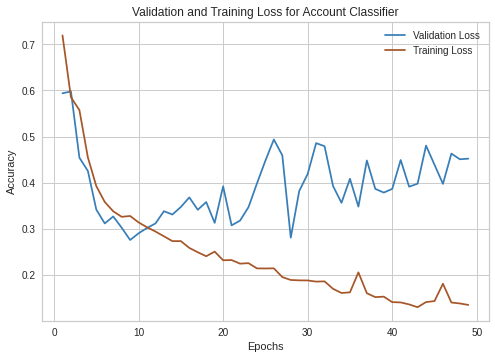

Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.09199872443452944, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 0.766646901002297 Training Accuracy 0.5594660194174758 Validation Accuracy: 0.5825242718446602, Validation loss: 0.6380617319282994
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.606211621600848 Training Accuracy 0.6635315533980582 Validation Accuracy: 0.7487864077669902, Validation loss: 0.5857482556326007
Re-setting early stopping
Training epoch 2
Epoch: 2 Training loss: 0.5071960097322097 Training Accuracy 0.7697208737864077 Validation Accuracy: 0.8507281553398058, Validation loss: 0.4251179163936453
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0.514420707638447 Tra

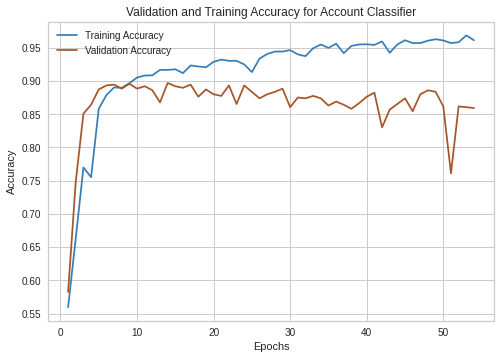

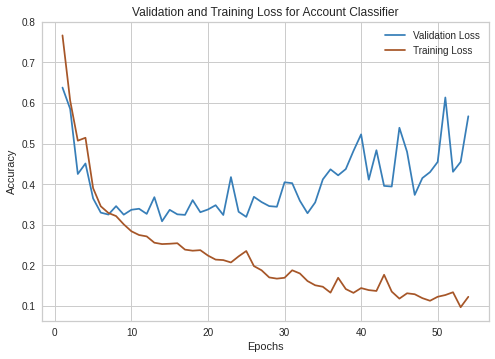

Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.09199872443452944, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 0.7018498852849007 Training Accuracy 0.6692961165048543 Validation Accuracy: 0.7233009708737864, Validation loss: 0.5939968780812264
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.5256266476443181 Training Accuracy 0.7548543689320388 Validation Accuracy: 0.7912621359223301, Validation loss: 0.6133516055640198
Possibly early stopping will be neccesary 1
Training epoch 2
Epoch: 2 Training loss: 0.45927494993576634 Training Accuracy 0.8140169902912622 Validation Accuracy: 0.8203883495145631, Validation loss: 0.498979566254861
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0

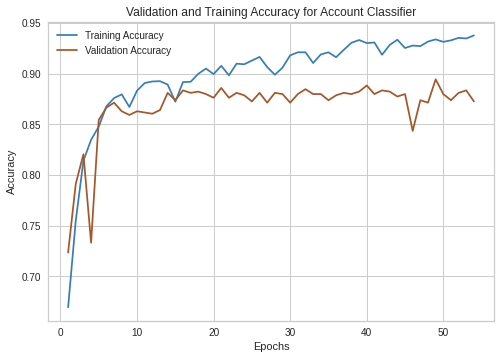

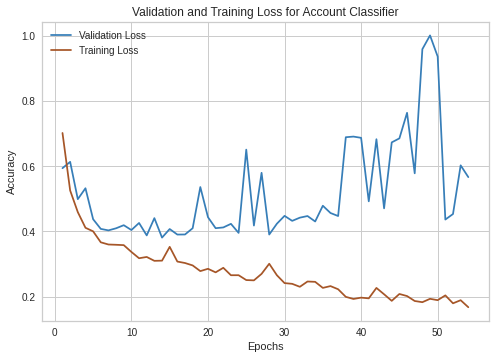

Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.09199872443452944, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 0.6741169381600159 Training Accuracy 0.6422936893203883 Validation Accuracy: 0.7220873786407767, Validation loss: 0.5446009702106839
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.5264219464017794 Training Accuracy 0.7399878640776699 Validation Accuracy: 0.6893203883495146, Validation loss: 0.5279986235195572
Re-setting early stopping
Training epoch 2
Epoch: 2 Training loss: 0.47761100416000074 Training Accuracy 0.7679004854368932 Validation Accuracy: 0.7803398058252428, Validation loss: 0.4933992238241718
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0.4373137409297319

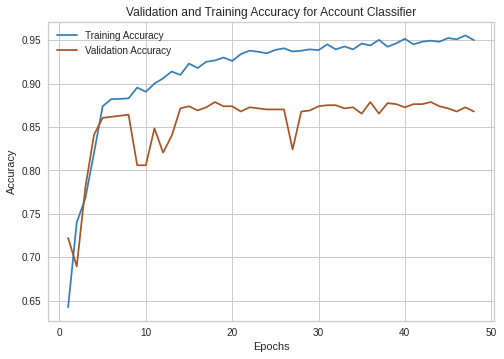

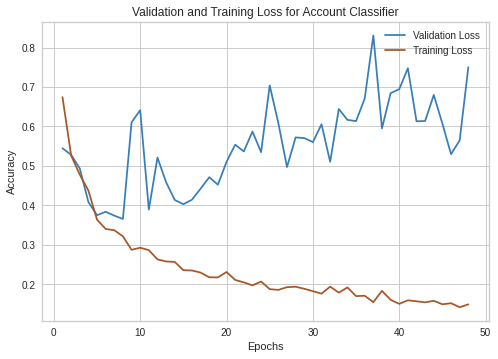

09:44:50.623250


In [ ]:
from sklearn.model_selection import KFold
print(datetime.datetime.now().time())
index = 0
folds = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in folds.split(h_train):
  X_train, X_test, Y_train, Y_test = h_train[train_index], h_train[test_index], y_train_kfold[train_index], y_train_kfold[test_index]
  lengths = [100]*len(X_train)
  account_classifier = AccountClassifier(input_size=32,
                                     batch_size = 64,
                                     lstm_layers = 2,
                                     lr = 0.008054089118348883,
                                     lstm_hidden_size=32,
                                     fc_drouput=0.0919987244345294404,
                                     lstm_dropout=0.4999474677953669,
                                     nn_size = 128,
                                     weight_decay=9.184335087470999e-08,
                                     bidirectional = True, n_eopchs_stop=40)
 
  account_classifier.train_model(X_train, Y_train, X_test, lengths, Y_test, epochs=250)
  torch.save(account_classifier, f'account_classifier_{index}')
  index +=1
  
print(datetime.datetime.now().time())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4660858318795682, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 0.6903488337993622 Training Accuracy 0.5230582524271845 Validation Accuracy: 0.5679611650485437, Validation loss: 0.652149223669396
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.67955960218723 Training Accuracy 0.5266990291262136 Validation Accuracy: 0.741504854368932, Validation loss: 0.5609459046142184
Re-setting early stopping
Training epoch 2
Epoch: 2 Training loss: 0.6696208142317258 Training Accuracy 0.5361043689320388 Validation Accuracy: 0.7803398058252428, Validation loss: 0.5179243042053466
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0.668808869444407 Training

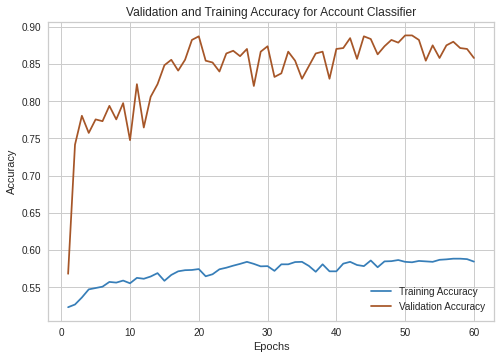

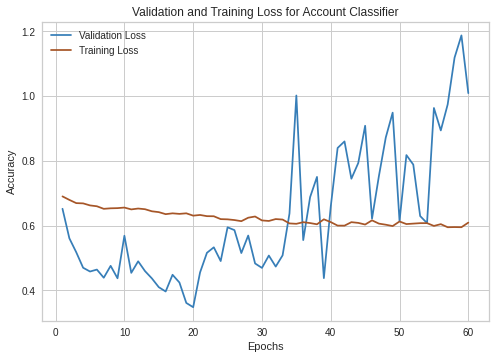

IndexError: ignored

In [ ]:
from sklearn.model_selection import KFold

index = 0
folds = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in folds.split(h_train):
  X_train, X_test, Y_train, Y_test, lengths = h_train_aug[train_index], h_train_aug[test_index], y_train_kfold_aug[train_index], y_train_kfold_aug[test_index], lengths[train_index]

  account_classifier = AccountClassifier(input_size=32,
                                     batch_size = 64,
                                     lstm_layers = 2,
                                     lr = 0.008945226129329248,
                                     lstm_hidden_size=32,
                                     fc_drouput=0.4660858318795682,
                                     lstm_dropout=0.4999474677953669,
                                     nn_size = 32,
                                     weight_decay=1.1472383449699353e-06,
                                     bidirectional = True, n_eopchs_stop=40)
 
  account_classifier.train_model(X_train, Y_train, X_test, lengths, Y_test, epochs=250)
  torch.save(account_classifier, f'account_classifier_{index}')
  index +=1

In [ ]:
accoutn_classifier_0 = torch.load('account_classifier_0')
accoutn_classifier_1 = torch.load('account_classifier_1')
accoutn_classifier_2 = torch.load('account_classifier_2')
accoutn_classifier_3 = torch.load('account_classifier_3')
accoutn_classifier_4 = torch.load('account_classifier_4')

In [ ]:
y_pred_test = [0]*len(accounts_h_test_norm)
y_prob_test = [0]*len(accounts_h_test_norm)

In [ ]:
pred, _, prob = accoutn_classifier_0.get_prediction(accounts_h_test_norm, y_test)
y_pred_test = [x+y for x,y in zip(y_pred_test, pred)]
y_prob_test = [x+y for x,y in zip(y_prob_test, prob)]

pred, _, prob = accoutn_classifier_1.get_prediction(accounts_h_test_norm, y_test)
y_pred_test = [x+y for x,y in zip(y_pred_test, pred)]
y_prob_test = [x+y for x,y in zip(y_prob_test, prob)]

pred, _, prob = accoutn_classifier_2.get_prediction(accounts_h_test_norm, y_test)
y_pred_test = [x+y for x,y in zip(y_pred_test, pred)]
y_prob_test = [x+y for x,y in zip(y_prob_test, prob)]

pred, _, prob = accoutn_classifier_3.get_prediction(accounts_h_test_norm, y_test)
y_pred_test = [x+y for x,y in zip(y_pred_test, pred)]
y_prob_test = [x+y for x,y in zip(y_prob_test, prob)]

pred, _, prob = accoutn_classifier_4.get_prediction(accounts_h_test_norm, y_test)
y_pred_test = [x+y for x,y in zip(y_pred_test, pred)]
y_prob_test = [x+y for x,y in zip(y_prob_test, prob)]

In [ ]:
majority_pred = []
for p in y_pred_test:
  if p>2:
    majority_pred.append(1)
  else:
    majority_pred.append(0)

In [ ]:
majority_prob = []
for p in y_prob_test:
  if p>2.5:
    majority_prob.append(1)
  else:
    majority_prob.append(0)

In [ ]:
evaulate(majority_pred, y_test)

Accuracy: 0.8897727272727273
F1 Score: 0.8912962271199103
Precision: 0.8791451731761238
Recall: 0.9037878787878788
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1320
           1       0.88      0.90      0.89      1320

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640

Confusion Matrix:
[[1156  164]
 [ 127 1193]]


0.8912962271199103

In [ ]:
evaulate(majority_prob, y_test)

Accuracy: 0.8920454545454546
F1 Score: 0.8935375420246543
Precision: 0.8813559322033898
Recall: 0.906060606060606
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1320
           1       0.88      0.91      0.89      1320

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640

Confusion Matrix:
[[1159  161]
 [ 124 1196]]


0.8935375420246543

In [ ]:
majority_pred[1]

1

Using GPU...
AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4660858318795682, inplace=False)
)
Using GPU...
Starting to train the model
Training epoch 0
Epoch: 0 Training loss: 0.6749708339020059 Training Accuracy 0.5370370370370371 Validation Accuracy: 0.7725806451612903, Validation loss: 0.48466260940343003
Re-setting early stopping
Training epoch 1
Epoch: 1 Training loss: 0.6570994648668501 Training Accuracy 0.5521990740740741 Validation Accuracy: 0.8379032258064516, Validation loss: 0.4191239348062687
Re-setting early stopping
Training epoch 2
Epoch: 2 Training loss: 0.6460651653784293 Training Accuracy 0.5584490740740741 Validation Accuracy: 0.8564516129032258, Validation loss: 0.3814343641104525
Re-setting early stopping
Training epoch 3
Epoch: 3 Training loss: 0.6477831809609025 Tr

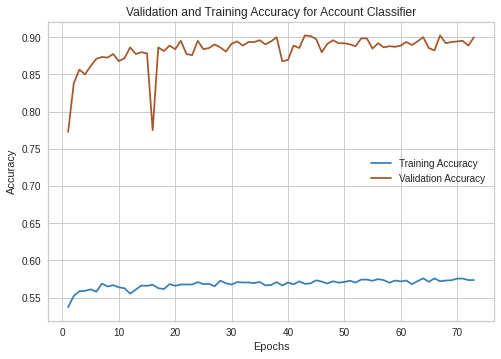

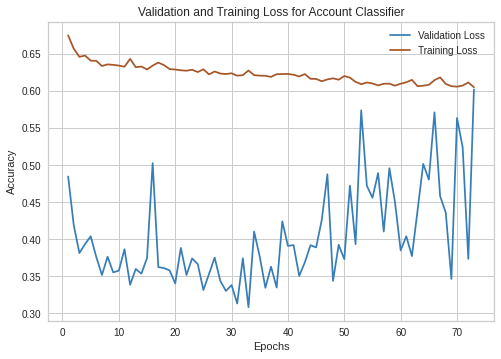

AccountClassifier(
  (lstm): LSTM(32, 32, num_layers=2, dropout=0.4999474677953669, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4660858318795682, inplace=False)
)

In [ ]:
account_classifier = AccountClassifier(input_size=32,
                                    batch_size = 64,
                                    lstm_layers = 2,
                                    lr = 0.008945226129329248,
                                    lstm_hidden_size=32,
                                    fc_drouput=0.4660858318795682,
                                    lstm_dropout=0.4999474677953669,
                                    nn_size = 32,
                                    weight_decay=1.1472383449699353e-06,
                                    bidirectional = True, n_eopchs_stop=40)

account_classifier.train_model(accounts_h_train_augmented, y_augmented, accounts_h_val_norm, lengths, y_val, epochs=250)

In [ ]:
y_account_test_pred, loss = account_classifier.get_prediction(accounts_h_test_norm, y_test)

NameError: ignored

In [ ]:
evaulate(y_account_test_pred, y_test)

NameError: ignored